In [7]:
import os
import random

def sample_crema_d(audio_dir, video_dir, sample_percentage=0.2):

    audio_files = os.listdir(audio_dir)
    video_files = os.listdir(video_dir)

    num_samples = int(len(audio_files) * sample_percentage)
    sampled_audio_files = random.sample(audio_files, num_samples)

    sampled_video_files = [f.replace('.wav', '.flv') for f in sampled_audio_files]

    sampled_audio_paths = [os.path.join(audio_dir, f) for f in sampled_audio_files]
    sampled_video_paths = [os.path.join(video_dir, f) for f in sampled_video_files]

    return sampled_audio_paths, sampled_video_paths

In [8]:
!git clone https://github.com/CheyneyComputerScience/CREMA-D.git

audio_dir = os.path.join(os.getcwd(), "CREMA-D/AudioWAV")
video_dir = os.path.join(os.getcwd(), "CREMA-D/VideoFlash")

sampled_audio_paths, sampled_video_paths = sample_crema_d(audio_dir, video_dir, 0.05)

print("Sampled audio files:", sampled_audio_paths)
print("Sampled video files:", sampled_video_paths)

fatal: destination path 'CREMA-D' already exists and is not an empty directory.
Sampled audio files: ['/content/CREMA-D/AudioWAV/1039_TSI_HAP_XX.wav', '/content/CREMA-D/AudioWAV/1016_WSI_ANG_XX.wav', '/content/CREMA-D/AudioWAV/1037_MTI_FEA_XX.wav', '/content/CREMA-D/AudioWAV/1009_IOM_DIS_XX.wav', '/content/CREMA-D/AudioWAV/1008_TSI_DIS_XX.wav', '/content/CREMA-D/AudioWAV/1026_TIE_ANG_XX.wav', '/content/CREMA-D/AudioWAV/1057_TAI_SAD_XX.wav', '/content/CREMA-D/AudioWAV/1048_IEO_ANG_HI.wav', '/content/CREMA-D/AudioWAV/1053_IWW_HAP_XX.wav', '/content/CREMA-D/AudioWAV/1006_IWL_SAD_XX.wav', '/content/CREMA-D/AudioWAV/1019_IOM_DIS_XX.wav', '/content/CREMA-D/AudioWAV/1010_TSI_FEA_XX.wav', '/content/CREMA-D/AudioWAV/1032_DFA_SAD_XX.wav', '/content/CREMA-D/AudioWAV/1009_WSI_FEA_XX.wav', '/content/CREMA-D/AudioWAV/1065_TIE_DIS_XX.wav', '/content/CREMA-D/AudioWAV/1013_IEO_DIS_MD.wav', '/content/CREMA-D/AudioWAV/1003_TAI_FEA_XX.wav', '/content/CREMA-D/AudioWAV/1067_DFA_FEA_XX.wav', '/content/CREMA-

In [9]:
import os
import subprocess

video_dir = os.path.expanduser("/content/CREMA-D/VideoFlash")
output_dir = os.path.expanduser("/content/CREMA-D/VideoMP4")
os.makedirs(output_dir, exist_ok=True)

for filename in os.listdir(video_dir):
    if filename.endswith(".flv"):
        input_path = os.path.join(video_dir, filename)
        output_path = os.path.join(output_dir, filename[:-4] + ".mp4")
        subprocess.run(["ffmpeg", "-i", input_path, output_path])
        print(f"Converted {filename} to {filename[:-4] + '.mp4'}")

In [12]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv3D, MaxPooling2D, MaxPooling3D, Dense, Dropout, Flatten, Concatenate
from tensorflow.keras.utils import to_categorical
import re
import seaborn as sns

In [13]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)


In [14]:
def sample_crema_d(audio_dir, video_dir, text_file, sample_percentage=0.05):
    """Sample a portion of the CREMA-D dataset"""
    audio_files = [f for f in os.listdir(audio_dir) if f.endswith('.wav')]
    num_samples = int(len(audio_files) * sample_percentage)
    sampled_audio_files = random.sample(audio_files, num_samples)
    sampled_video_files = [f.replace('.wav', '.mp4') for f in sampled_audio_files]
    sampled_audio_paths = [os.path.join(audio_dir, f) for f in sampled_audio_files]
    sampled_video_paths = [os.path.join(video_dir, f) for f in sampled_video_files]

    labels_df = pd.read_csv(text_file)
    sampled_ids = [os.path.splitext(f)[0] for f in sampled_audio_files]

    sampled_data = []
    for file_id in sampled_ids:
        parts = file_id.split('_')
        if len(parts) >= 3:
            actor_id = parts[0]
            emotion = parts[2]
            sampled_data.append({
                'file_id': file_id,
                'actor_id': actor_id,
                'emotion': emotion,
                'audio_path': os.path.join(audio_dir, file_id + '.wav'),
                'video_path': os.path.join(video_dir, file_id + '.mp4')
            })

    data_df = pd.DataFrame(sampled_data)
    return data_df


In [15]:
def preprocess_audio(audio_path, n_mfcc=13, max_length=100):
    """Extract MFCC features from audio file"""
    try:
        y, sr = librosa.load(audio_path, sr=None)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        if mfccs.shape[1] < max_length:
            pad_width = max_length - mfccs.shape[1]
            mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            mfccs = mfccs[:, :max_length]
        mfccs = mfccs.reshape(1, mfccs.shape[0], mfccs.shape[1], 1)
        return mfccs
    except Exception as e:
        print(f"Error processing audio {audio_path}: {e}")
        return np.zeros((1, n_mfcc, max_length, 1))


In [16]:
def preprocess_video(video_path, frame_count=16, height=64, width=64):
    """Extract frames from video for 3D-CNN"""
    try:
        cap = cv2.VideoCapture(video_path)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        if total_frames <= frame_count:
            frames_to_sample = list(range(total_frames))
        else:
            frames_to_sample = np.linspace(0, total_frames-1, frame_count, dtype=int)

        frames = np.zeros((frame_count, height, width, 3), dtype=np.float32)

        for i, frame_idx in enumerate(frames_to_sample):
            if i >= frame_count:
                break
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
            ret, frame = cap.read()
            if ret:
                frame = cv2.resize(frame, (width, height))
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame = frame / 255.0
                frames[i] = frame

        cap.release()
        frames = frames.reshape(1, frame_count, height, width, 3)
        return frames
    except Exception as e:
        print(f"Error processing video {video_path}: {e}")
        return np.zeros((1, frame_count, height, width, 3))


In [17]:
def create_simple_embedding_dict(vocab, embedding_dim=100):
    """Create a simple embedding dictionary for words"""
    embedding_dict = {}
    for word in vocab:
        embedding_dict[word.lower()] = np.random.randn(embedding_dim)
    return embedding_dict


In [18]:
def preprocess_text(file_id, embedding_dict, embedding_dim=100, max_length=20):
    """Create text embedding from file ID using simple embedding dictionary"""
    words = re.findall(r'[A-Za-z]+', file_id)
    embeddings = np.zeros((max_length, embedding_dim))
    for i, word in enumerate(words):
        if i >= max_length:
            break
        word_lower = word.lower()
        if word_lower in embedding_dict:
            embeddings[i] = embedding_dict[word_lower]
    embeddings = embeddings.reshape(1, max_length, embedding_dim)
    return embeddings


In [19]:
def perform_eda(data_df):
    """Perform exploratory data analysis"""
    print("Dataset Overview:")
    print(f"Total samples: {len(data_df)}")

    emotion_counts = data_df['emotion'].value_counts()
    print("\nEmotion Distribution:")
    print(emotion_counts)

    plt.figure(figsize=(10, 6))
    emotion_counts.plot(kind='bar', color='skyblue')
    plt.title('Emotion Distribution in Dataset')
    plt.xlabel('Emotion')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    if len(data_df) > 0:
        sample_audio_path = data_df.iloc[0]['audio_path']
        try:
            y, sr = librosa.load(sample_audio_path, sr=None)
            plt.figure(figsize=(12, 4))
            plt.subplot(1, 2, 1)
            plt.plot(np.linspace(0, len(y)/sr, len(y)), y)
            plt.title('Audio Waveform')
            plt.xlabel('Time (s)')
            plt.ylabel('Amplitude')

            plt.subplot(1, 2, 2)
            mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
            plt.imshow(mfccs, aspect='auto', origin='lower')
            plt.title('MFCC Features')
            plt.xlabel('Time Frames')
            plt.ylabel('MFCC Coefficients')
            plt.colorbar(format='%+2.0f dB')
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Error analyzing audio sample: {e}")

    return emotion_counts


In [20]:
def build_multimodal_model(audio_shape, video_shape, text_shape, num_classes):
    """Build the multimodal emotion recognition model"""
    audio_input = Input(shape=audio_shape, name='audio_input')
    x_audio = Conv2D(32, (3, 3), activation='relu')(audio_input)
    x_audio = MaxPooling2D((2, 2))(x_audio)
    x_audio = Conv2D(64, (3, 3), activation='relu')(x_audio)
    x_audio = MaxPooling2D((2, 2))(x_audio)
    x_audio = Flatten()(x_audio)
    x_audio = Dense(128, activation='relu')(x_audio)
    audio_features = Dense(64, activation='relu', name='audio_features')(x_audio)

    video_input = Input(shape=video_shape, name='video_input')
    x_video = Conv3D(32, (3, 3, 3), activation='relu')(video_input)
    x_video = MaxPooling3D((1, 2, 2))(x_video)
    x_video = Conv3D(64, (3, 3, 3), activation='relu')(x_video)
    x_video = MaxPooling3D((1, 2, 2))(x_video)
    x_video = Flatten()(x_video)
    x_video = Dense(128, activation='relu')(x_video)
    video_features = Dense(64, activation='relu', name='video_features')(x_video)

    text_input = Input(shape=text_shape, name='text_input')
    x_text = Flatten()(text_input)
    x_text = Dense(128, activation='relu')(x_text)
    text_features = Dense(64, activation='relu', name='text_features')(x_text)

    feature_fusion = Concatenate()([audio_features, video_features, text_features])
    x = Dense(128, activation='relu')(feature_fusion)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)

    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=[audio_input, video_input, text_input], outputs=outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


Sampling dataset...

Performing exploratory data analysis...
Dataset Overview:
Total samples: 276

Emotion Distribution:
emotion
HAP    57
ANG    52
FEA    48
DIS    47
SAD    41
NEU    31
Name: count, dtype: int64


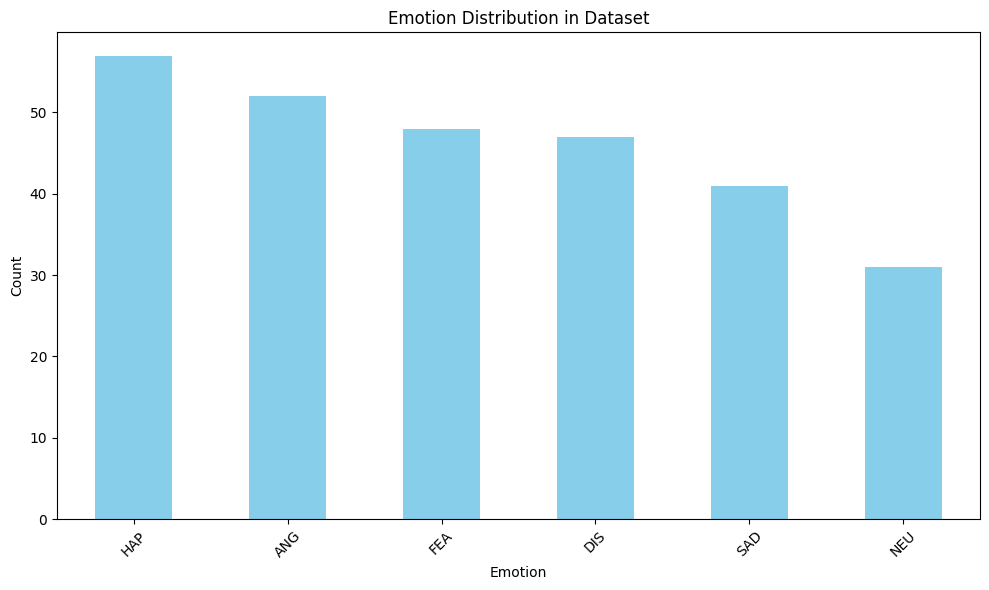

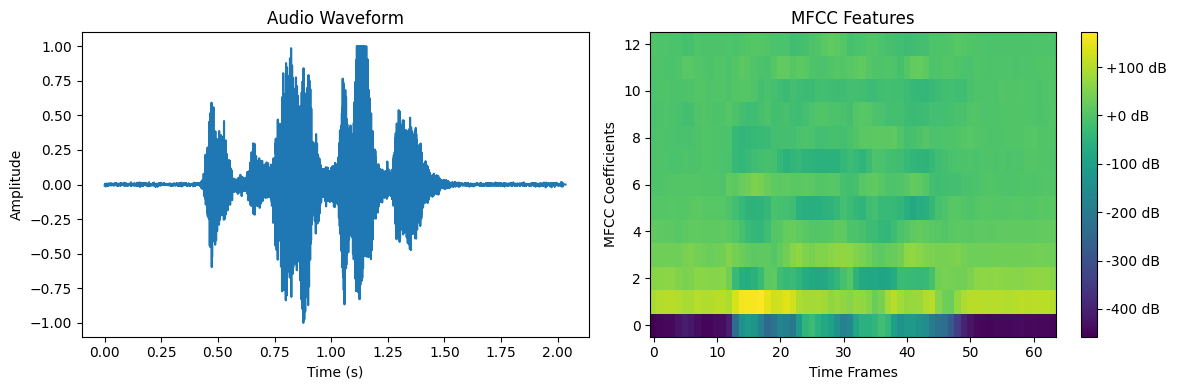


Creating word embeddings...

Training set: 220 samples
Test set: 56 samples

Input shapes - Audio: (13, 100, 1), Video: (16, 64, 64, 3), Text: (20, 100)

Building multimodal model...


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ audio_input         │ (None, 13, 100,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ video_input         │ (None, 16, 64,    │          0 │ -                 │
│ (InputLayer)        │ 64, 3)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 11, 98,    │        320 │ audio_input[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_4 (Conv3D)   │ (None, 14, 62,    │      2,624 │ video_input[0][0] │
│                     │ 62, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 5, 49, 32) │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_4     │ (None, 14, 31,    │          0 │ conv3d_4[0][0]    │
│ (MaxPooling3D)      │ 31, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 3, 47, 64) │     18,496 │ max_pooling2d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_5 (Conv3D)   │ (None, 12, 29,    │     55,360 │ max_pooling3d_4[… │
│                     │ 29, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 1, 23, 64) │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_5     │ (None, 12, 14,    │          0 │ conv3d_5[0][0]    │
│ (MaxPooling3D)      │ 14, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_input          │ (None, 20, 100)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_6 (Flatten) │ (None, 1472)      │          0 │ max_pooling2d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_7 (Flatten) │ (None, 150528)    │          0 │ max_pooling3d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_8 (Flatten) │ (None, 2000)      │          0 │ text_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 128)       │    188,544 │ flatten_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 128)       │ 19,267,712 │ flatten_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 128)       │    256,128 │ flatten_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ audio_features      │ (None, 64)        │      8,256 │ dense_12[0][0]    │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ video_features      │ (None, 64)        │      8,256 │ dense_13[0][0]    │
│ (Dense)             │                   │            │                 

 Total params: 19,847,302 (75.71 MB)

 Trainable params: 19,847,302 (75.71 MB)

 Non-trainable params: 0 (0.00 B)


To train the model, uncomment the train_model() call above.
After training, the model accuracy will be printed and visualized.


In [21]:

# Main execution
if __name__ == "__main__":
    # Define paths
    audio_dir = "CREMA-D/AudioWAV"
    video_dir = "CREMA-D/VideoMP4"  # Using MP4 files converted from FLV
    text_file = "CREMA-D/processedResults/summaryTable.csv"

    # Sample dataset
    print("Sampling dataset...")
    data_df = sample_crema_d(audio_dir, video_dir, text_file)

    # Perform EDA
    print("\nPerforming exploratory data analysis...")
    emotion_counts = perform_eda(data_df)

    # Encode emotion labels
    le = LabelEncoder()
    data_df['emotion_encoded'] = le.fit_transform(data_df['emotion'])
    num_classes = len(le.classes_)

    # Create simple word embeddings instead of using Word2Vec
    print("\nCreating word embeddings...")
    vocab = set(word for file_id in data_df['file_id'] for word in re.findall(r'[A-Za-z]+', file_id))
    embedding_dim = 100
    embedding_dict = create_simple_embedding_dict(vocab, embedding_dim)

    # Split data
    train_df, test_df = train_test_split(data_df, test_size=0.2, stratify=data_df['emotion'], random_state=42)

    print(f"\nTraining set: {len(train_df)} samples")
    print(f"Test set: {len(test_df)} samples")

    # Process a single sample to determine input shapes
    sample_row = data_df.iloc[0]
    audio_sample = preprocess_audio(sample_row['audio_path'])
    video_sample = preprocess_video(sample_row['video_path'])
    text_sample = preprocess_text(sample_row['file_id'], embedding_dict, embedding_dim)

    audio_shape = audio_sample.shape[1:]
    video_shape = video_sample.shape[1:]
    text_shape = text_sample.shape[1:]

    print(f"\nInput shapes - Audio: {audio_shape}, Video: {video_shape}, Text: {text_shape}")

    # Build model
    print("\nBuilding multimodal model...")
    model = build_multimodal_model(
        audio_shape=audio_shape,
        video_shape=video_shape,
        text_shape=text_shape,
        num_classes=num_classes
    )

    # Display model summary
    model.summary()

    # Train the model (uncomment to run)
    # model, history, final_accuracy = train_model(
    #     model=model,
    #     train_df=train_df,
    #     test_df=test_df,
    #     embedding_dict=embedding_dict,
    #     batch_size=16,
    #     epochs=10
    # )

    print("\nTo train the model, uncomment the train_model() call above.")
    print("After training, the model accuracy will be printed and visualized.")